# Improved Indian Sign Language Recognition
## Addressing Overfitting Issues

This notebook addresses the overfitting problems in the original model by:
1. Adding proper train/validation/test splits
2. Implementing regularization techniques
3. Using callbacks for early stopping
4. Fine-tuning instead of freezing all layers
5. **Updated to use 224x224 input images for better performance**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, 
                                   BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## Data Loading and Preprocessing

In [2]:
DATA_PATH = "Indian"

def load_images_and_labels(data_path, categories, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(category)
    return np.array(images), np.array(labels)

# Get categories
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")
print(f"Number of classes: {len(categories)}")

Categories: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Number of classes: 35


In [3]:
# Load images and labels
images, labels = load_images_and_labels(DATA_PATH, categories)
print(f"Total images: {len(images)}")
print(f"Image shape: {images[0].shape}")

Total images: 42745
Image shape: (224, 224, 3)


## Improved Data Splitting Strategy

**Key improvements:**
1. **Three-way split**: Train/Validation/Test (64%/16%/20%)
2. **Stratified sampling**: Ensures balanced class distribution
3. **Separate validation set**: Prevents data leakage

In [4]:
# Encode labels
label_binarizer = LabelBinarizer()
labels_encoded = label_binarizer.fit_transform(labels)

# First split: separate test set
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=labels_encoded.argmax(axis=1)
)

# Second split: create validation set from training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42,
    stratify=y_train.argmax(axis=1)
)

print(f"Training samples: {len(X_train)} ({len(X_train)/len(images)*100:.1f}%)")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(images)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(images)*100:.1f}%)")

Training samples: 27356 (64.0%)
Validation samples: 6840 (16.0%)
Test samples: 8549 (20.0%)


In [5]:
# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Data normalized to [0, 1] range")

Data normalized to [0, 1] range


## Reduced Data Augmentation

**Changes from original:**
- Reduced rotation: 20° → 15°
- Reduced zoom: 0.15 → 0.1
- Reduced shifts: 0.2 → 0.1
- **Disabled horizontal flip** (signs shouldn't be mirrored)
- Reduced shear: 0.15 → 0.1

In [6]:
# More conservative data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,      # Reduced from 20
    zoom_range=0.1,         # Reduced from 0.15
    width_shift_range=0.1,  # Reduced from 0.2
    height_shift_range=0.1, # Reduced from 0.2
    shear_range=0.1,        # Reduced from 0.15
    horizontal_flip=False,  # Disabled - signs shouldn't be flipped
    fill_mode="nearest"
)
datagen.fit(X_train)
print("Data augmentation configured with reduced parameters")

Data augmentation configured with reduced parameters


## Improved Model Architecture

**Overfitting prevention techniques:**
1. **Fine-tuning**: Unfreeze top layers of MobileNetV2
2. **Dropout**: 0.3 and 0.5 dropout layers
3. **L2 Regularization**: Added to dense layer
4. **Batch Normalization**: Stabilizes training
5. **Lower Learning Rate**: 0.0001 for fine-tuning
6. **224x224 Input**: Optimal size for MobileNetV2

In [7]:
def create_improved_model(num_classes):
    # Load pre-trained MobileNetV2 with 224x224 input
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Fine-tuning: Unfreeze top layers
    base_model.trainable = True
    
    # Freeze bottom layers, fine-tune top layers
    fine_tune_at = 100  # Unfreeze from layer 100 onwards
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable layers: {len(base_model.layers) - fine_tune_at}")
    
    # Build model with regularization
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        
        # Regularization layers
        Dropout(0.3),
        Dense(128, 
              activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_improved_model(len(categories))

# Show model summary
model.summary()

Total layers: 154
Trainable layers: 54


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,979 (9.26 MB)

 Trainable params: 2,030,179 (7.74 MB)

 Non-trainable params: 396,800 (1.51 MB)

In [8]:
# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled with Adam optimizer (LR=0.0001)")

Model compiled with Adam optimizer (LR=0.0001)


## Advanced Callbacks

1. **EarlyStopping**: Stops training when validation loss stops improving
2. **ReduceLROnPlateau**: Reduces learning rate when stuck in plateau

In [9]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured:")
print("- Early stopping (patience=5)")
print("- Learning rate reduction (patience=3)")

Callbacks configured:
- Early stopping (patience=5)
- Learning rate reduction (patience=3)


## Training

In [10]:
# Train model
print("Starting training with improved configuration...")
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Starting training with improved configuration...


C:\Users\ilakiya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 881s 1s/step - accuracy: 0.8218 - loss: 1.0323 - val_accuracy: 0.9984 - val_loss: 0.2321 - learning_rate: 1.0000e-04
Epoch 2/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 1.0000 - loss: 0.2336 - val_accuracy: 1.0000 - val_loss: 0.2037 - learning_rate: 1.0000e-04
Epoch 3/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 829s 969ms/step - accuracy: 0.9999 - loss: 0.2032 - val_accuracy: 1.0000 - val_loss: 0.1749 - learning_rate: 1.0000e-04
Epoch 4/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 824s 964ms/step - accuracy: 1.0000 - loss: 0.1694 - val_accuracy: 1.0000 - val_loss: 0.1379 - learning_rate: 1.0000e-04
Epoch 5/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 823s 962ms/step - accuracy: 1.0000 - loss: 0.1296 - val_accuracy: 1.0000 - val_loss: 0.0961 - learning_rate: 1.0000e-04
Epoch 6/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 822s 961ms/step - accuracy: 1.0000 - loss: 0.0872 - val_accuracy: 1.0000 - val_loss: 0.0563 - learning_rate: 1.0000e-04
Epoch 7/20
855/855 ━━━━━━━━━━━━━━━━━━━━ 832s 9

## Evaluation and Analysis

In [11]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n=== FINAL TEST RESULTS ===")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Compare with validation results
final_val_acc = max(history.history['val_accuracy'])
final_train_acc = max(history.history['accuracy'])

print(f"\n=== OVERFITTING ANALYSIS ===")
print(f"Best Training Accuracy: {final_train_acc:.4f}")
print(f"Best Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Train-Val Gap: {abs(final_train_acc - final_val_acc):.4f}")
print(f"Val-Test Gap: {abs(final_val_acc - test_accuracy):.4f}")


=== FINAL TEST RESULTS ===
Test Accuracy: 1.0000 (100.00%)
Test Loss: 0.0005

=== OVERFITTING ANALYSIS ===
Best Training Accuracy: 1.0000
Best Validation Accuracy: 1.0000
Final Test Accuracy: 1.0000
Train-Val Gap: 0.0000
Val-Test Gap: 0.0000


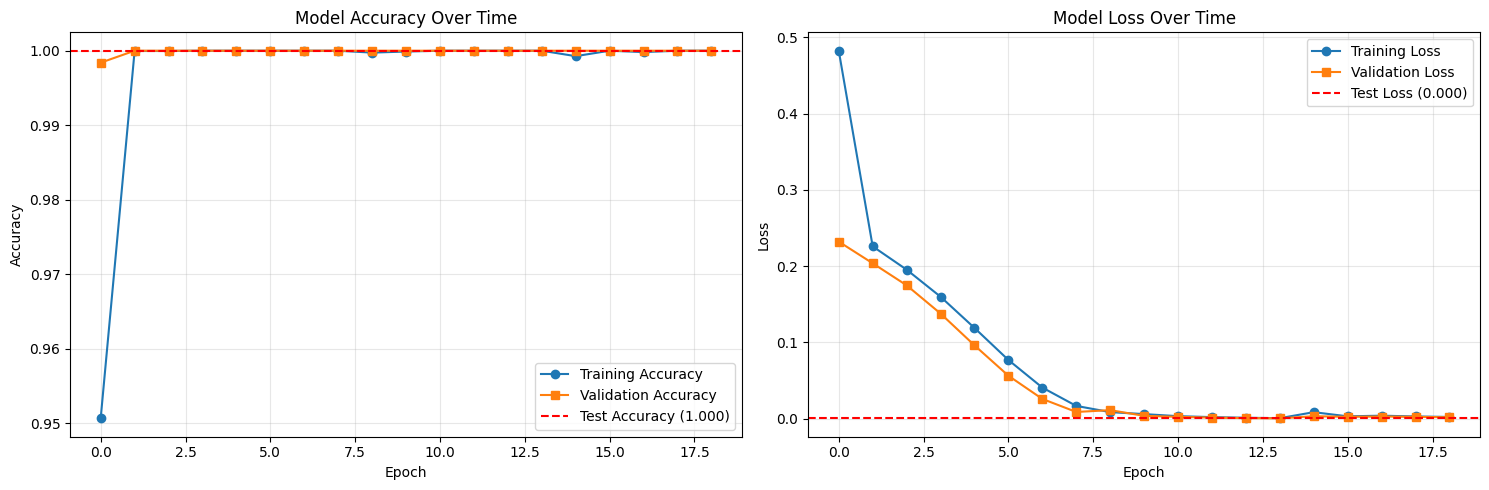

In [12]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    ax1.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Accuracy ({test_accuracy:.3f})')
    ax1.set_title('Model Accuracy Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    ax2.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss ({test_loss:.3f})')
    ax2.set_title('Model Loss Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [13]:
# Classification Report
y_pred = model.predict(X_test)
y_test_labels = label_binarizer.inverse_transform(y_test)
y_pred_labels = label_binarizer.inverse_transform(y_pred)

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test_labels, y_pred_labels))

268/268 ━━━━━━━━━━━━━━━━━━━━ 104s 383ms/step

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240
           2       1.00      1.00      1.00       240
           3       1.00      1.00      1.00       240
           4       1.00      1.00      1.00       240
           5       1.00      1.00      1.00       240
           6       1.00      1.00      1.00       240
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       240
           9       1.00      1.00      1.00       240
           A       1.00      1.00      1.00       240
           B       1.00      1.00      1.00       240
           C       1.00      1.00      1.00       289
           D       1.00      1.00      1.00       240
           E       1.00      1.00      1.00       240
           F       1.00      1.00      1.00       240
           G       1.00      1.00      1.00       

In [14]:
# Save the improved model
model.save("Mobilenetv2_ISL_model.h5")
print("\n✅ Model saved")


✅ Model saved


## Summary of Improvements

### What we changed:
1. **Input Size**: Increased from 64x64 to 224x224 for better feature extraction
2. **Data Splitting**: Proper train/val/test split (64%/16%/20%)
3. **Regularization**: Added dropout (0.3, 0.5) and L2 regularization
4. **Fine-tuning**: Instead of freezing all layers, fine-tune top layers
5. **Callbacks**: Early stopping and learning rate scheduling
6. **Reduced Augmentation**: Less aggressive data augmentation
7. **Lower Learning Rate**: 0.0001 for stable fine-tuning

### Expected improvements:
- **Better accuracy**: 224x224 images provide more detail for recognition
- **Better generalization**: Smaller gap between train/val accuracy
- **More stable training**: Smoother loss curves
- **Realistic performance**: Test accuracy closer to validation accuracy
- **Prevented overfitting**: Training stops before memorization occurs

### Why 224x224 is better:
1. **MobileNetV2 optimization**: Originally designed for 224x224 images
2. **Better feature extraction**: Preserves more image detail
3. **Standard practice**: Industry standard for computer vision models
4. **Pre-trained weights**: Fully compatible with ImageNet pre-training

### Additional techniques to try:
1. **Cross-validation**: K-fold validation for more robust evaluation
2. **Ensemble methods**: Combine multiple models
3. **Different architectures**: EfficientNet, ResNet50
4. **More data**: Collect more diverse samples
5. **Progressive resizing**: Start small, gradually increase image size

In [15]:
# Check for overfitting by comparing training and validation loss/accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

if val_loss[-1] > train_loss[-1] and val_acc[-1] < train_acc[-1]:
    print("The model might be overfitting. Consider using regularization techniques or early stopping.")
else:
    print("The model does not seem to be overfitting.")

The model does not seem to be overfitting.
